### Con esta primera celda podemos grabar un video con la webcam y almacenarlo para ser utilizado posteriormente en los script para medir Heart Rate y Breath Rate

In [33]:
import cv2
import time


def video_cap():
    
    #Frames vars to control video capture
    capture_duration = 26
    frame_time = 10  # time of each frame in ms


    # video capture
    capture = cv2.VideoCapture(0)
    # Encoding
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    # Write and save
    out = cv2.VideoWriter('record.avi',fourcc, 20.0, (640,480))
    start_time = time.time()

    # Time interval
    while(int(time.time() - start_time) < capture_duration):
        ret, frame = capture.read()
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        out.write(frame)
        cv2.imwrite('./data/image.png',frame)
        cv2.imshow('Vide Capture', gray)
        if cv2.waitKey(frame_time) & 0xFF == ord('q'):
            break

    capture.release()
    out.release()
    cv2.destroyAllWindows()


if __name__ == '__main__':
    video_cap()

## A continuaciòn utilizaremos la libreria pyVHR para obtener un array con los valores de BPM(Beats per minute) o latidos por minuto, que en caso de ser una persona sana seran iguales a su frecuencia cardiaca.

### Ademàs en las proximas celdas ejecutaremos la libreria pyVHR con distintos metodos de medicion, los cuales fueron escogidos por mi persona segùn el desempeño de cada uno

### 1) Metodo cpu_CHROM


Processing Video: Video el 26-4-22 poca luz.mov

BVP extraction with method: cpu_CHROM

BPM estimation with: welch

...done!



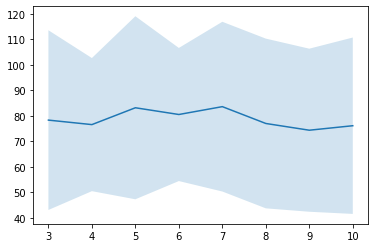

29.243122816085815


In [44]:
from pyVHR.analysis.pipeline import Pipeline
import matplotlib.pyplot as plt
from pyVHR.analysis.multi_method_suite import TestResult
import heartpy as hp
import matplotlib.pyplot as plt
from filteringHR import filter_signal
import time

inicio = time.time()
pipe = Pipeline()
times, BPM, uncertainty = pipe.run_on_video(r"Video el 26-4-22 poca luz.mov", 
                                           roi_approach="patches", 
                                           roi_method="convexhull",method='cpu_CHROM',bpm_type='welch',
                                           pre_filt=False,verb=1) 
#bpm welch , psd_clustering #roi_approach hol , patches
#roi_method faceparsing , convexhull
# pre_filt True , False 
#post_filt True , False

plt.figure()
plt.plot(times, BPM)
plt.fill_between(times, BPM-uncertainty, BPM+uncertainty, alpha=0.2)
plt.show()



fin = float(time.time())
print(fin-inicio)

#### Obtenemos un array llamado BPM con los valores obtenidos por segundo del video

In [45]:
BPM_cpu_CHROM=BPM
BPM_cpu_CHROM

array([78.29794312, 76.53843689, 83.13658142, 80.49732208, 83.57645416,
       76.97831726, 74.33905792, 76.09855652])

#### Luego calculamos los valores de R-R (Ritmo Regular) que utilizaremos para calcular la frencuencia de respiracion (Breath Rate), para ello es necesario aplicar la siguiente formula:  R-R=60000/BPM

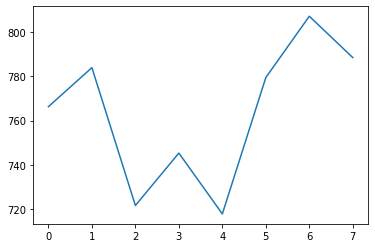

In [46]:
rr_list_cpu_CHROM = 60000 / BPM_cpu_CHROM
plt.figure()
plt.plot(rr_list_cpu_CHROM)
plt.show()

### 2) Metodo cpu_PCA


Processing Video: Video el 26-4-22 poca luz.mov

BVP extraction with method: cpu_PCA

BPM estimation with: welch

...done!



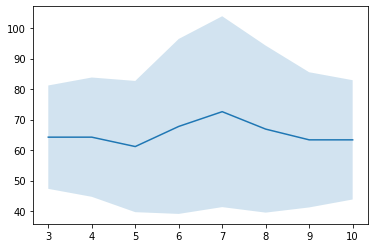

31.108763694763184


In [47]:
inicio = time.time()
pipe = Pipeline()
times, BPM, uncertainty = pipe.run_on_video(r"Video el 26-4-22 poca luz.mov", 
                                           roi_approach="patches", 
                                           roi_method="convexhull",method='cpu_PCA',bpm_type='welch',
                                           pre_filt=False,verb=1) 
#bpm welch , psd_clustering #roi_approach hol , patches
#roi_method faceparsing , convexhull
# pre_filt True , False 
#post_filt True , False

plt.figure()
plt.plot(times, BPM)
plt.fill_between(times, BPM-uncertainty, BPM+uncertainty, alpha=0.2)
plt.show()



fin = float(time.time())
print(fin-inicio)

In [48]:
BPM_cpu_PCA=BPM
BPM_cpu_PCA

array([64.22190857, 64.22190857, 61.14277649, 67.74092102, 72.5795517 ,
       66.86116028, 63.34215546, 63.34215546])

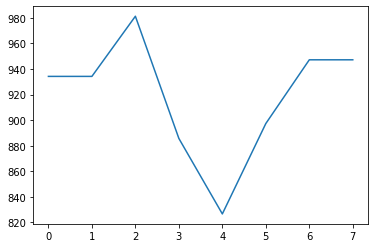

In [49]:
rr_list_cpu_PCA = 60000 / BPM_cpu_PCA
plt.figure()
plt.plot(rr_list_cpu_PCA)
plt.show()

### 3) Metodo torch_CHROM


Processing Video: Video el 26-4-22 poca luz.mov

BVP extraction with method: torch_CHROM

BPM estimation with: welch

...done!



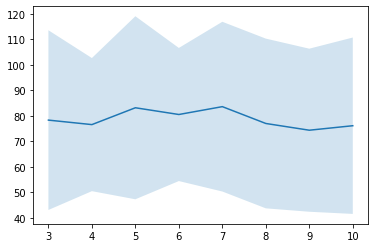

32.12836503982544


In [50]:
inicio = time.time()
pipe = Pipeline()
times, BPM, uncertainty = pipe.run_on_video(r"Video el 26-4-22 poca luz.mov", 
                                           roi_approach="patches", 
                                           roi_method="convexhull",method='torch_CHROM',bpm_type='welch',
                                           pre_filt=False,verb=1) 
#bpm welch , psd_clustering #roi_approach hol , patches
#roi_method faceparsing , convexhull
# pre_filt True , False 
#post_filt True , False

plt.figure()
plt.plot(times, BPM)
plt.fill_between(times, BPM-uncertainty, BPM+uncertainty, alpha=0.2)
plt.show()



fin = float(time.time())
print(fin-inicio)

In [51]:
BPM_torch_CHROM=BPM
BPM_torch_CHROM

array([78.29794312, 76.53843689, 83.13658142, 80.49732208, 83.57645416,
       76.97831726, 74.33905792, 76.09855652])

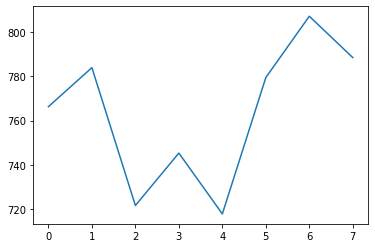

In [52]:
rr_list_torch_CHROM = 60000 / BPM_torch_CHROM
plt.figure()
plt.plot(rr_list_torch_CHROM)
plt.show()

### A continuacion, definimos la funcion que usaremos para calcular el breath rate extraida de la libreria heartpy, especificamente del ejecutable analisis.py

In [53]:
def calc_breathing(rrlist, method='welch', filter_breathing=True,
                   bw_cutoff=[0.1, 0.4], measures={}, working_data={}):
    
    '''estimates breathing rate

    Function that estimates breathing rate from heart rate signal.
    Upsamples the list of detected rr_intervals by interpolation then
    tries to extract breathing peaks in the signal.

    Parameters
    ----------
    rr_list : 1d list or array
        list or array containing peak-peak intervals

    method : str
        method to use to get the spectrogram, must be 'fft' or 'welch'
        default : fft

    filter_breathing : bool
        whether to filter the breathing signal derived from the peak-peak intervals
        default : True

    bw_cutoff : list or tuple
        breathing frequency range expected
        default : [0.1, 0.4], meaning between 6 and 24 breaths per minute

    measures : dict
        dictionary object used by heartpy to store computed measures. Will be created
        if not passed to function.

    working_data : dict
        dictionary object that contains all heartpy's working data (temp) objects.
        will be created if not passed to function

    Returns
    -------
    measures : dict
        dictionary object used by heartpy to store computed measures.

    Examples
    --------
    Normally this function is called during the process pipeline of HeartPy. It can
    of course also be used separately.

    Let's load an example and get a list of peak-peak intervals

    >>> import heartpy as hp
    >>> data, _ = hp.load_exampledata(0)
    >>> wd, m = hp.process(data, 100.0)

    Breathing is then computed with the function

    >>> m, wd = calc_breathing(wd['RR_list_cor'], measures = m, working_data = wd)
    >>> round(m['breathingrate'], 3)
    0.171

    There we have it, .17Hz, or about one breathing cycle in 6.25 seconds.
    '''

    #resample RR-list to 1000Hz
    x = np.linspace(0, len(rrlist), len(rrlist))
    x_new = np.linspace(0, len(rrlist), np.sum(rrlist, dtype=np.int32))
    interp = UnivariateSpline(x, rrlist, k=3)
    breathing = interp(x_new)
    #print('this is x',x)
    #print('this is x_new:',x_new)
    #print('this is interp:', interp)
    #print('this is breathing:', breathing)

    if filter_breathing:
        breathing = hp.filtering.filter_signal(breathing, cutoff=bw_cutoff,
                                               sample_rate = 1000.0, filtertype='bandpass')

    if method.lower() == 'fft':
        datalen = len(breathing)
        frq = np.fft.fftfreq(datalen, d=((1/1000.0)))
        frq = frq[range(int(datalen/2))]
        Y = np.fft.fft(breathing)/datalen
        Y = Y[range(int(datalen/2))]
        psd = np.power(np.abs(Y), 2)
    elif method.lower() == 'welch':
        if len(breathing) < 30000:
            frq, psd = welch(breathing, fs=1000, nperseg=len(breathing))
        else:
            frq, psd = welch(breathing, fs=1000, nperseg=np.clip(len(breathing) // 10,
                                                                 a_min=30000, a_max=None))
    elif method.lower() == 'periodogram':
        frq, psd = periodogram(breathing, fs=1000.0, nfft=30000)

    else:
        raise ValueError('Breathing rate extraction method not understood! Must be \'welch\' or \'fft\'!')

    #find max
    measures['breathingrate'] = frq[np.argmax(psd)]
    working_data['breathing_signal'] = breathing
    working_data['breathing_psd'] = psd
    working_data['breathing_frq'] = frq

    return measures, working_data

### Luego ejecutamos la funcion para los distintos metodos utilizados para la extracciòn de los BPM, y ademas los compareremos con los metodos "welch" y "periodogram" para calcular el breath rate

#### Metodo BPM: cpu_CHROM, Metodo Breath Rate: welch

In [54]:
import numpy as np
import pandas as pd
from scipy.interpolate import UnivariateSpline
from scipy.signal import welch, periodogram
measures, working_data=calc_breathing(rr_list_cpu_CHROM, method='welch', filter_breathing=True,
                   bw_cutoff=[0.1, 0.4], measures={}, working_data={})

In [55]:
round(measures['breathingrate'], 3)

0.164

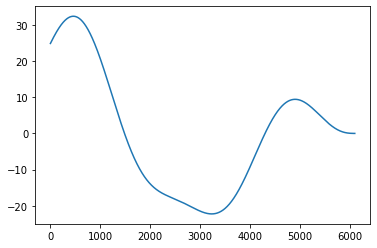

In [56]:
plt.figure()
plt.plot(working_data['breathing_signal'])
plt.show()

#### Metodo BPM: cpu_CHROM, Metodo Breath Rate: periodogram

In [57]:
measures, working_data1=calc_breathing(rr_list_cpu_CHROM, method='periodogram', filter_breathing=True,
                   bw_cutoff=[0.1, 0.4], measures={}, working_data={})

In [58]:
round(measures['breathingrate'], 3)

0.2

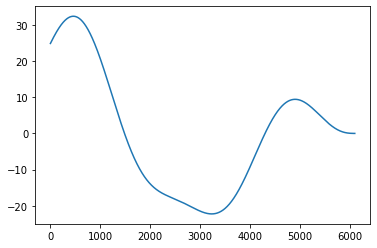

In [59]:
plt.figure()
plt.plot(working_data1['breathing_signal'])
plt.show()

#### Metodo BPM: cpu_PCA, Metodo Breath Rate: welch

In [60]:
measures, working_data2=calc_breathing(rr_list_cpu_PCA, method='welch', filter_breathing=True,
                   bw_cutoff=[0.1, 0.4], measures={}, working_data={})

In [61]:
round(measures['breathingrate'], 3)

0.272

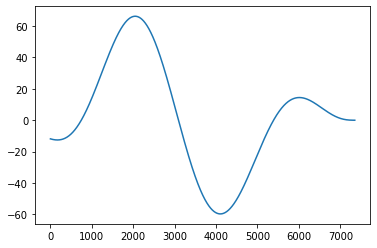

In [62]:
plt.figure()
plt.plot(working_data2['breathing_signal'])
plt.show()

#### Metodo BPM: cpu_PCA, Metodo Breath Rate: periodogram

In [63]:
measures, working_data3=calc_breathing(rr_list_cpu_PCA, method='periodogram', filter_breathing=True,
                   bw_cutoff=[0.1, 0.4], measures={}, working_data={})

In [64]:
round(measures['breathingrate'], 3)

0.233

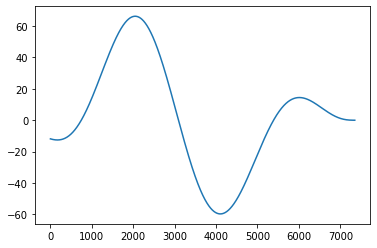

In [65]:
plt.figure()
plt.plot(working_data3['breathing_signal'])
plt.show()

#### Metodo BPM: torch_CHROM, Metodo Breath Rate: welch

In [66]:
measures, working_data4=calc_breathing(rr_list_torch_CHROM, method='welch', filter_breathing=True,
                   bw_cutoff=[0.1, 0.4], measures={}, working_data={})

In [67]:
round(measures['breathingrate'], 3)

0.164

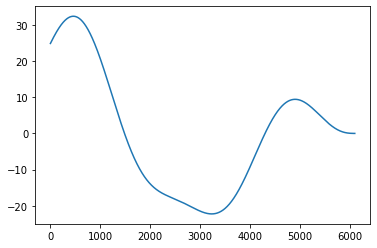

In [68]:
plt.figure()
plt.plot(working_data4['breathing_signal'])
plt.show()

#### Metodo BPM: torch_CHROM, Metodo Breath Rate: periodogram

In [69]:
measures, working_data5=calc_breathing(rr_list_torch_CHROM, method='periodogram', filter_breathing=True,
                   bw_cutoff=[0.1, 0.4], measures={}, working_data={})

In [70]:
round(measures['breathingrate'], 3)

0.2

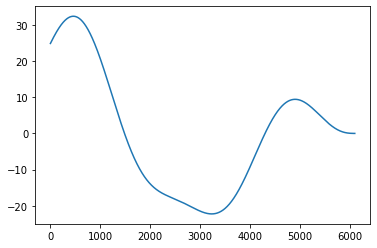

In [71]:
plt.figure()
plt.plot(working_data5['breathing_signal'])
plt.show()

Frequency Domain
Frequency domain measures computed are:

low-frequency, frequency spectrum between 0.05-0.15Hz (LF)
high-frequency, frequency spectrum between 0.15-0.5Hz (HF)
the ration high frequency / low frequency (HF/LF)
The measures are computed from the PSD (Power Spectral Density), which itself is estimated using either FFT-based, Periodogram-based, or Welch-based methods. The default is Welch’s method.

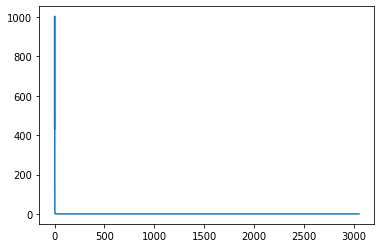

In [72]:
plt.figure()
plt.plot(working_data['breathing_psd'])

plt.show()

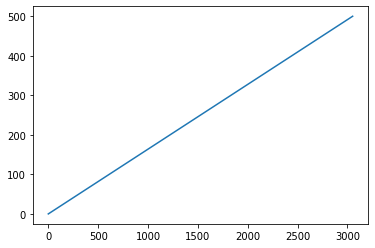

In [73]:
plt.figure()
plt.plot(working_data['breathing_frq'])

plt.show()